# Определение перспективного тарифа для телеком-компании

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. 

Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. Даны 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Примечание**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

**Цель исследования -** установить тариф, который приносит больше денег

**Ход исследования**
1. Изучение данных.
2. Предобработка данных.
3. Анализ данных.
4. Проверка гипотезы.
5. Подготовка общего вывода.

## Изучение данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

### Звонки

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Согласно документации:

* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок

### Интернет

In [5]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Согласно документации:

* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя

### Сообщения

In [7]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [8]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Согласно документации:

* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение

### Тарифы

In [9]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [10]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Согласно документации:

* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Пользователи

In [11]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Согласно документации:

* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tariff` — название тарифного плана

### Вывод

Данные состоят из 5 таблиц: 3 таблицы с платными действиями пользователей (звонки, интернет, сообщения), таблица с информацией о пользователях, таблица с информацией о тарифах. Пропуски в данных отсутствуют (кроме столбца churn_date в таблице с пользователями), у некоторых столбцов необходимо изменить тип данных.

## Предобработка данных

### Изменение типов данных

Необходимо изменить типы данных для следующих столбцов:
* все столбцы с датой - поменять object на datetime
* длительность звонков - округлить в большую сторону, сделать целочисленным

In [13]:
# меняем тип данных для столбцов с датой
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [14]:
calls['duration'] = np.ceil(calls['duration']) # округляем звонки в большую сторону
calls['duration'] = calls['duration'].astype('int') # меняем тип данных
calls.head() # проверяем

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


### Поиск ошибок в данных

Проверим данные на наличие дубликатов и артефактов.

**Пользователи**

In [15]:
# создадим новый столбец с именем и фамилией через пробел
users['full_name'] = users['first_name'].map(str) + ' ' + users['last_name'].map(str)

In [16]:
# проверим наличие дубликатов
users['full_name'].duplicated().sum() 

0

In [17]:
users['age'].describe() # проверим наличие выбросов

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

In [18]:
users['city'].sort_values().unique() # проверим наличие неявных дубликатов

array(['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород',
       'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград',
       'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург',
       'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга',
       'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск',
       'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва',
       'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород',
       'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск',
       'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск',
       'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара',
       'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск',
       'Сочи', 'Ставрополь', 'Стерлитамак', 'Сургут', 'Тамбов', 'Тверь',
       'Тольятти', 'Томск', 'Тула', 'Тюмень', 'Улан-Удэ', 'Ульяновск',
       'Уфа', 'Хабаровск', 'Химки', 'Чебоксары', 'Челябинск', 'Череповец',
       'Чи

**Звонки**

In [19]:
calls['duration'].describe()

count    202607.000000
mean          7.158198
std           5.959173
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64

Отрицательные и слишком большие значения отсутствуют. Нулями обозначены пропущенные звонки.

**Интернет**

In [20]:
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

<AxesSubplot:>

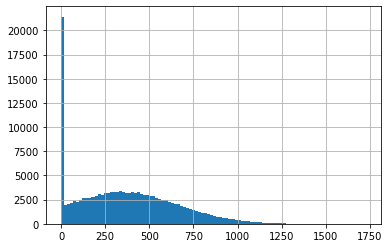

In [21]:
internet['mb_used'].hist(bins=100)

Обнаружены нулевые значения

In [22]:
internet[internet['mb_used'] == 0]['mb_used'].count() # проверим количество нулевых значений

19598

In [23]:
internet = internet[internet['mb_used'] != 0] # удаляем все нулевые значения
internet['mb_used'].describe() # проверяем

count    129798.000000
mean        426.087210
std         255.596447
min           0.030000
25%         227.460000
50%         400.540000
75%         592.947500
max        1724.830000
Name: mb_used, dtype: float64

**Выводы**

Найдены нулевые значения в таблице с интернет-трафиком. В документации нет пояснения, откуда могли появиться подобные значения. Было решено от них избавиться, т.к. они могут помешать анализу. 

### Подсчет дополнительных характеристик

Необходимо подсчитать для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [24]:
# создаем столбцы с номером месяца
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

In [25]:
# количество сделанных звонков и израсходованных минут разговора по месяцам
calls_pivot = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=('count', 'sum'))
calls_pivot = calls_pivot.reset_index()
calls_pivot.columns = ['user_id', 'month', 'calls_count', 'calls_sum']
calls_pivot.head()

,user_id,month,calls_count,calls_sum
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


In [26]:
# количество отправленных сообщений по месяцам
messages_pivot = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_pivot = messages_pivot.reset_index()
messages_pivot.columns = ['user_id', 'month', 'messages_count']
messages_pivot.head()

,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [27]:
# объем израсходованного интернет-трафика по месяцам
internet_pivot = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
internet_pivot = internet_pivot.reset_index()
internet_pivot.head()

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


In [28]:
# поменяем название столбца tariff_name в таблице tariffs
tariffs.columns = (
    ['messages_included',
    'mb_per_month_included',
    'minutes_included',
    'rub_monthly_fee',
    'rub_per_gb',
    'rub_per_message',
    'rub_per_minute',
    'tariff']
)

In [29]:
# объединим все таблицы
data = (
    calls_pivot.merge(messages_pivot, on=['user_id', 'month'], how='outer')
    .merge(internet_pivot, on=['user_id', 'month'], how='outer')
    .merge(users, on='user_id', how='inner')
    .merge(tariffs, on='tariff', how='inner')
)
data.head()

,user_id,month,calls_count,calls_sum,messages_count,mb_used,age,churn_date,city,first_name,...,reg_date,tariff,full_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22.0,159.0,22.0,2253.49,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,Рафаил Верещагин,1000,30720,3000,1950,150,1,1
1,1000,6,43.0,172.0,60.0,23233.77,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,Рафаил Верещагин,1000,30720,3000,1950,150,1,1
2,1000,7,47.0,340.0,75.0,14003.64,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,Рафаил Верещагин,1000,30720,3000,1950,150,1,1
3,1000,8,52.0,408.0,81.0,14055.93,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,Рафаил Верещагин,1000,30720,3000,1950,150,1,1
4,1000,9,58.0,466.0,57.0,14568.91,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,Рафаил Верещагин,1000,30720,3000,1950,150,1,1


In [30]:
# проверим, все ли пользователи добавлены
data.user_id.unique().shape 

(498,)

В таблицу не попали два пользователя. Необходимо выяснить, кто они и почему не присоединились.

In [31]:
good_users = data.user_id.unique()
users.query('user_id not in @good_users')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,full_name
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,Ксения Агаева
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,Ириней Трофимов


In [32]:
calls.query('user_id == 1128')

,id,call_date,duration,user_id,month


In [33]:
calls.query('user_id == 1371')

,id,call_date,duration,user_id,month


В выгрузке отсутствуют данные об использовании услуг компании пользователями с id 1128 и 1371. Добавлять их в расчет не имеет смысла.

В столбцах с звонками, сообщениями и гигабайтами есть пропуски. Они возникли из-за отсутствия активности пользователей в определенные месяцы. Логично будет заполнить пропуски нулями - услуги ведь не потреблялись.

In [36]:
data['calls_count'] = data['calls_count'].fillna(0)
data['calls_sum'] = data['calls_sum'].fillna(0)
data['messages_count'] = data['messages_count'].fillna(0)
data['mb_used'] = data['mb_used'].fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int64         
 2   calls_count            3214 non-null   float64       
 3   calls_sum              3214 non-null   float64       
 4   messages_count         3214 non-null   float64       
 5   mb_used                3214 non-null   float64       
 6   age                    3214 non-null   int64         
 7   churn_date             187 non-null    object        
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff                 3214 non-null   object        
 13  ful

In [37]:
# создадим функцию, рассчитывающую помесячную выручку с каждого пользователя
def income_calc(row):
    calls_sum = row['calls_sum']
    messages_count = row['messages_count']
    mb_used = row['mb_used']
    tariff = row['tariff']
    messages_included = row['messages_included']
    mb_per_month_included = row['mb_per_month_included']
    minutes_included = row['minutes_included']
    rub_monthly_fee = row['rub_monthly_fee']
    rub_per_gb = row['rub_per_gb']
    rub_per_message = row['rub_per_message']
    rub_per_minute = row['rub_per_minute']
    income = 0
    if calls_sum > minutes_included:
        income += (calls_sum - minutes_included) * rub_per_minute
    if messages_count > messages_included:
        income += (messages_count - messages_included) * rub_per_message
    if mb_used > mb_per_month_included:
        income += np.ceil((mb_used - mb_per_month_included) / 1024) * rub_per_gb
    income += rub_monthly_fee
    return income

data['income'] = data.apply(income_calc, axis=1)
data.head()

,user_id,month,calls_count,calls_sum,messages_count,mb_used,age,churn_date,city,first_name,...,tariff,full_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,income
0,1000,5,22.0,159.0,22.0,2253.49,52,NaN,Краснодар,Рафаил,...,ultra,Рафаил Верещагин,1000,30720,3000,1950,150,1,1,1950.0
1,1000,6,43.0,172.0,60.0,23233.77,52,NaN,Краснодар,Рафаил,...,ultra,Рафаил Верещагин,1000,30720,3000,1950,150,1,1,1950.0
2,1000,7,47.0,340.0,75.0,14003.64,52,NaN,Краснодар,Рафаил,...,ultra,Рафаил Верещагин,1000,30720,3000,1950,150,1,1,1950.0
3,1000,8,52.0,408.0,81.0,14055.93,52,NaN,Краснодар,Рафаил,...,ultra,Рафаил Верещагин,1000,30720,3000,1950,150,1,1,1950.0
4,1000,9,58.0,466.0,57.0,14568.91,52,NaN,Краснодар,Рафаил,...,ultra,Рафаил Верещагин,1000,30720,3000,1950,150,1,1,1950.0


## Анализ данных

Опишем поведение клиентов оператора, исходя из выборки. Определим, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы. Опишем распределения.

In [38]:
# разделим датасет на две части, по названию тарифа
data_ultra = data.query('tariff == "ultra"')
data_smart = data.query('tariff == "smart"')
# подсчитаем объемы полученных выборок
display(
    'Количество пользователей тарифа ultra', len(data_ultra['user_id'].unique()),
    'Количество пользователей тарифа smart', len(data_smart['user_id'].unique()),
)

'Количество пользователей тарифа ultra'

148

'Количество пользователей тарифа smart'

350

### Звонки

In [39]:
# вычислим основные статистические характеристики тарифа ultra
display(
    'Тариф ultra',
    'Среднее', data_ultra['calls_sum'].mean(),
    'Дисперсия', np.var(data_ultra['calls_sum'], ddof=1),
    'Стандартное отклонение', np.std(data_ultra['calls_sum'], ddof=1)
)

'Тариф ultra'

'Среднее'

526.6233502538071

'Дисперсия'

100873.63339730098

'Стандартное отклонение'

317.6060978591264

In [40]:
# вычислим основные статистические характеристики тарифа smart
display(
    'Тариф smart',
    'Среднее', data_smart['calls_sum'].mean(),
    'Дисперсия', np.var(data_smart['calls_sum'], ddof=1),
    'Стандартное отклонение', np.std(data_smart['calls_sum'], ddof=1)
)

'Тариф smart'

'Среднее'

417.9349484073576

'Дисперсия'

36219.31578434428

'Стандартное отклонение'

190.31372988921288

<AxesSubplot:ylabel='Frequency'>

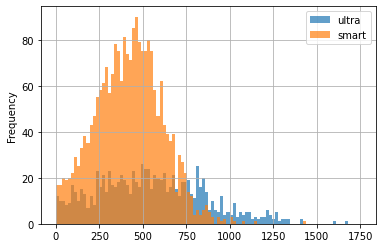

In [41]:
ax = data_ultra.plot(kind='hist', y='calls_sum', range=(1,1750), bins=100, alpha=0.7, label='ultra')
data_smart.plot(kind='hist', y='calls_sum', range=(1,1750), bins=100, alpha=0.7, label='smart', ax=ax, grid=True, legend=True)

### Сообщения

In [42]:
# вычислим основные статистические характеристики тарифа ultra
display(
    'Тариф ultra',
    'Среднее', data_ultra['messages_count'].mean(),
    'Дисперсия', np.var(data_ultra['messages_count'], ddof=1),
    'Стандартное отклонение', np.std(data_ultra['messages_count'], ddof=1)
)

'Тариф ultra'

'Среднее'

49.36345177664975

'Дисперсия'

2285.2661425446736

'Стандартное отклонение'

47.804457350174715

In [43]:
# вычислим основные статистические характеристики тарифа smart
display(
    'Тариф smart',
    'Среднее', data_smart['messages_count'].mean(),
    'Дисперсия', np.var(data_smart['messages_count'], ddof=1),
    'Стандартное отклонение', np.std(data_smart['messages_count'], ddof=1)
)

'Тариф smart'

'Среднее'

33.384028712427096

'Дисперсия'

796.8129584480083

'Стандартное отклонение'

28.22787555676141

<AxesSubplot:ylabel='Frequency'>

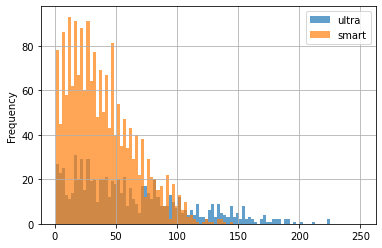

In [44]:
ax = data_ultra.plot(kind='hist', y='messages_count', range=(1,250), bins=100, alpha=0.7, label='ultra')
data_smart.plot(kind='hist', y='messages_count', range=(1,250), bins=100, alpha=0.7, label='smart', ax=ax, grid=True, legend=True)

### Интернет

In [45]:
# вычислим основные статистические характеристики тарифа ultra
display(
    'Тариф ultra',
    'Среднее', data_ultra['mb_used'].mean(),
    'Дисперсия', np.var(data_ultra['mb_used'], ddof=1),
    'Стандартное отклонение', np.std(data_ultra['mb_used'], ddof=1)
)

'Тариф ultra'

'Среднее'

19468.805208121827

'Дисперсия'

101751013.78335385

'Стандартное отклонение'

10087.170752166034

In [46]:
# вычислим основные статистические характеристики тарифа smart
display(
    'Тариф smart',
    'Среднее', data_smart['mb_used'].mean(),
    'Дисперсия', np.var(data_smart['mb_used'], ddof=1),
    'Стандартное отклонение', np.std(data_smart['mb_used'], ddof=1)
)

'Тариф smart'

'Среднее'

16208.386989681472

'Дисперсия'

34462496.46274242

'Стандартное отклонение'

5870.476681049199

<AxesSubplot:ylabel='Frequency'>

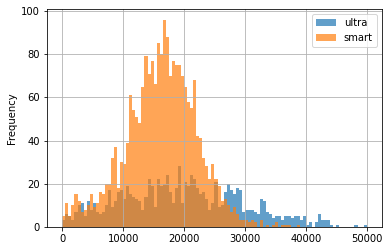

In [47]:
ax = data_ultra.plot(kind='hist', y='mb_used', range=(1,50000), bins=100, alpha=0.7, label='ultra')
data_smart.plot(kind='hist', y='mb_used', range=(1,50000), bins=100, alpha=0.7, label='smart', ax=ax, grid=True, legend=True)

### Выручка

In [48]:
# вычислим основные статистические характеристики тарифа ultra
display(
    'Тариф ultra',
    'Среднее', data_ultra['income'].mean(),
    'Дисперсия', np.var(data_ultra['income'], ddof=1),
    'Стандартное отклонение', np.std(data_ultra['income'], ddof=1)
)

'Тариф ultra'

'Среднее'

2070.1522842639592

'Дисперсия'

141516.7450786183

'Стандартное отклонение'

376.1871144505328

In [49]:
# вычислим основные статистические характеристики тарифа smart
display(
    'Тариф smart',
    'Среднее', data_smart['income'].mean(),
    'Дисперсия', np.var(data_smart['income'], ddof=1),
    'Стандартное отклонение', np.std(data_smart['income'], ddof=1)
)

'Тариф smart'

'Среднее'

1289.9735307312696

'Дисперсия'

669785.7080064242

'Стандартное отклонение'

818.4043670499469

<AxesSubplot:ylabel='Frequency'>

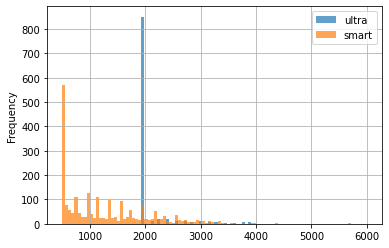

In [50]:
# построим гистограмму частоты распределения выручки по обоим тарифам
ax = data_ultra.plot(kind='hist', y='income', range=(500, 6000), bins=100, alpha=0.7, label='ultra')
data_smart.plot(kind='hist', y='income', range=(500, 6000), bins=100, alpha=0.7, label='smart', ax=ax, grid=True, legend=True)

<AxesSubplot:xlabel='month'>

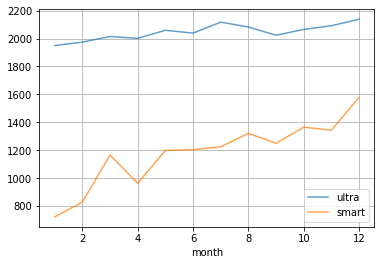

In [51]:
# посчитаем среднюю выручку по месяцам
data_ultra_month = data_ultra.pivot_table(index='month', values='income', aggfunc='mean')
data_ultra_month = data_ultra_month.reset_index()
data_smart_month = data_smart.pivot_table(index='month', values='income', aggfunc='mean')
data_smart_month = data_smart_month.reset_index()

# построим график изменения средней выручки по месяцам
ax = data_ultra_month.sort_values('month').plot(x='month', y='income', alpha=0.7, label='ultra')
data_smart_month.sort_values('month').plot(x='month', y='income', ax=ax, alpha=0.7, label='smart', grid=True, legend=True)

<AxesSubplot:xlabel='tariff'>

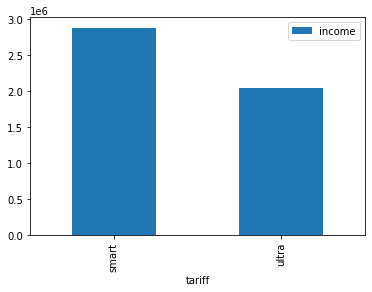

In [52]:
# подсчитаем суммарныю выручку за год по двум тарифам
data.pivot_table(index='tariff', values='income', aggfunc='sum').plot(y='income', kind='bar')

**Выводы**

В среднем, пользователям тарифа Ультра требуется примерно на 150 минут, 20 сообщений и 3 гб больше, чем пользователям тарифа Смарт. Средний доход пользователей Ультра составляет 2070, что близко к цене абонплаты. Средний доход Смарт составляет 1289, при этом на графике изменения средней выручки по месяцам видно, что у Смарта наблюдается стабильный рост. Доход Ультра также растет, но не сильно. Суммарная выручка за год показывает преимущество Смарт почти в милллион рублей.

## Проверка гипотез

### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Сформулируем гипотезу. За нулевую гипотезу примем утверждение о том, что средняя выручка пользователей «Ультра» равна средней выручке пользователей «Смарт». Альтернативной гипотезой будет утверждение о том, что средние выручки тарифов не равны. Будем использовать специальный метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам `ttest_ind`. Так как мы знаем, что выборки разного размера (148 против 350 пользователей), укажем в параметре `equal_var` значение `False`. Критический уровень статистической значимости установим в 5 %.

In [53]:
alpha = 0.05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    data_ultra['income'], 
    data_smart['income'], equal_var=False)

display('Средняя выручка тарифа Ультра:',  data_ultra['income'].mean())
display('Средняя выручка тарифа Смарт:',  data_smart['income'].mean())
display('p-значение:', results.pvalue)

if results.pvalue < alpha:
    display("Отвергаем нулевую гипотезу")
else:
    display("Не получилось отвергнуть нулевую гипотезу") 

'Средняя выручка тарифа Ультра:'

2070.1522842639592

'Средняя выручка тарифа Смарт:'

1289.9735307312696

'p-значение:'

4.2606313931076085e-250

'Отвергаем нулевую гипотезу'

**Вывод:**

Так как нулевая гипотеза отвергнута, мы принимаем альтернативную гипотезу - средняя выручка тарифов «Ультра» и «Смарт» различается. Сильное различие в средних подсказывает, в какую стророну направлено различие - среднее «Ультра» больше. 

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Сформулируем гипотезу. За нулевую гипотезу примем утверждение о том, что средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов. Альтернативной гипотезой будет утверждение о том, что средняя выручка различается. Методика проверки будет такой же, как в предыдущей проверке.

In [54]:
alpha = 0.05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    data.query('city == "Москва"')['income'], 
    data.query('city != "Москва"')['income'], equal_var=False)

display('Средняя выручка в Москве:', data.query('city == "Москва"')['income'].mean())
display('Средняя выручка в регионах:', data.query('city != "Москва"')['income'].mean())
display('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    display("Отвергаем нулевую гипотезу")
else:
    display("Не получилось отвергнуть нулевую гипотезу")

'Средняя выручка в Москве:'

1546.7135842880523

'Средняя выручка в регионах:'

1524.9362274298885

'p-значение:'

0.5257376663729298

'Не получилось отвергнуть нулевую гипотезу'

Отвергнуть нулевую гипотезу не получилось - средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов. Средние значения подтверждают вывод.

## Общий вывод

Проведено исследование доходности тарифных планов телеком оператора. Изучены исходные данные, проведена их предобработка - изменены типы данных в колонках, отброшены артефакты. Рассчитаны дополнительные характеристики, объединены таблицы. Проведен исследовательский анализ. Изучены параметры, влияющие на доходность тарифов - потребление пользователями минут, сообщений и мегабайт. Проведена проверка двух гипотез. 

1. Было выявлено, что в среднем пользователям тарифа «Ультра» требуется примерно на 150 минут, 20 сообщений и 3 гб больше, чем пользователям тарифа «Смарт».

2. Средняя выручка с пользователя выше у тарифа Ультра - 2070 против 1289 у Смарт.

3. График изменения средней выручки по месяцам показывает стабильный рост выручки у Смарта - практически в два раза на конец года.

4. Суммарная выручка за год показывает преимущество Смарт почти в милллион рублей. Из-за того что тарифом пользуется больше людей, он приносит больший доход.

2. Проверена гипотеза о том, что средняя выручка от пользователей тарифа «Ультра» отлична от выручки пользователей тарифа «Смарт». Гипотеза подтвердилась - выручки различаются.

3. Проверена гипотеза о том, что средняя выручка пользователей из Москвы отлична от выручки пользователей других регионов. Гипотеза не подтвердилась - средняя выручка не отличается в Москве и регионах.